In [8]:
import json
from glob import glob
import numpy as np
import pandas as pd

In [137]:
label_fname_list = glob("data/example_subset/Meerkat/test/*.json")

In [144]:
df = pd.DataFrame({"onset":[1,2,3],"cluster":["2","4","5"]})

In [148]:
{ k:v.tolist() for k,v in df.items() }

{'onset': [1, 2, 3], 'cluster': ['2', '4', '5']}

In [ ]:
species"zebra_finch"
sr32000
min_frequency0
spec_time_step0.0025
min_segment_length0.01
tolerance0.01
time_per_frame_for_scoring0.001
eps0.02

In [3]:
{}.get("AA","") is None

False

In [9]:
0.0025 * 10

0.025

In [2]:
from utils import RATIO_DECODING_TIME_STEP_TO_SPEC_TIME_STEP

In [3]:
from datautils import get_audio_and_label_paths, read_label

In [4]:
import soundfile as sf
def get_sampling_rate(file_path):
    with sf.SoundFile(file_path) as audio_file:
        sampling_rate = audio_file.samplerate
    return sampling_rate

In [30]:
max([3,4,5,6])

6

In [24]:
audio_paths, label_paths = get_audio_and_label_paths("data/example_subset/Zebra_finch/test_juveniles/")

In [25]:
determine_default_config(audio_paths, label_paths, total_spec_columns=1000)

0.0025


{'species': 'unkown',
 'sr': 32000,
 'min_frequency': 0,
 'spec_time_step': 0.0025,
 'min_segment_length': 0.005,
 'tolerance': 0.0125,
 'time_per_frame_for_scoring': 0.0025,
 'eps': 0.025}

In [16]:
def determine_default_config(audio_paths, label_paths, total_spec_columns):
    onsets = []
    offsets = []
    for label_path in label_paths:
        label = read_label(label_path)
        onsets += label["onset"]
        offsets += label["offset"]
    print(label["spec_time_step"])
    onsets = np.array(onsets)
    offsets = np.array(offsets)
    assert len(onsets) > 0, "No vocal segment is annotated in the label files."
    seg_dur_median = np.median( offsets - onsets )
    ## 20 is an empirical scale factor
    spec_time_step = np.ceil(seg_dur_median * 20 / 0.5) * 0.5  / total_spec_columns
    min_segment_length = spec_time_step * RATIO_DECODING_TIME_STEP_TO_SPEC_TIME_STEP
    tolerance = spec_time_step * 5
    time_per_frame_for_scoring = spec_time_step
    eps = spec_time_step * 10
    min_frequency = 0
    species = "unkown"
    sr_list = []
    for audio_fname in audio_paths:
        sr_list.append( get_sampling_rate( audio_fname ) )
    assert len(sr_list) > 0, "No valid audios were provided."
    sr = int(np.median(sr_list))
    return {
        "species": species,
        "sr":sr,
        "min_frequency":min_frequency,
        "spec_time_step":spec_time_step,
        "min_segment_length":min_segment_length,
        "tolerance":tolerance,
        "time_per_frame_for_scoring":time_per_frame_for_scoring,
        "eps":eps
    }

In [11]:
get_sampling_rate("data/example_subset/Bengalese_finch/test/bengalese_finch_bl26lb16_190412_0721.20144_0.wav")


32000

In [5]:
label

{'onset': [0.0116099771112203, 1.7385940551757812],
 'offset': [0.1102947872132062, 1.8459863439202309],
 'cluster': ['zebra_finch_0', 'zebra_finch_0'],
 'species': 'zebra_finch',
 'sr': 32000,
 'min_frequency': 0,
 'spec_time_step': 0.0025,
 'min_segment_length': 0.01,
 'tolerance': 0.01,
 'time_per_frame_for_scoring': 0.001,
 'eps': 0.02}

In [138]:
onsets = []
offsets = []
for fname in label_fname_list:
    label = json.load(open(fname))
    onsets += label["onset"]
    offsets += label["offset"]
onsets = np.array( onsets )
offsets = np.array( offsets )

In [139]:
label["spec_time_step"] * 1000

1.0

In [142]:
np.median( offsets - onsets ) * 20

2.780000000000271

In [141]:
np.percentile( offsets - onsets, 95 ) * 5

2.198749999999999

In [74]:
import matplotlib.pyplot as plt

(array([68., 43., 21., 47.,  7.,  1.,  2.,  1.,  0.,  1.]),
 array([0.01866213, 0.04689643, 0.07513072, 0.10336502, 0.13159932,
        0.15983361, 0.18806791, 0.21630221, 0.2445365 , 0.2727708 ,
        0.3010051 ]),
 <BarContainer object of 10 artists>)

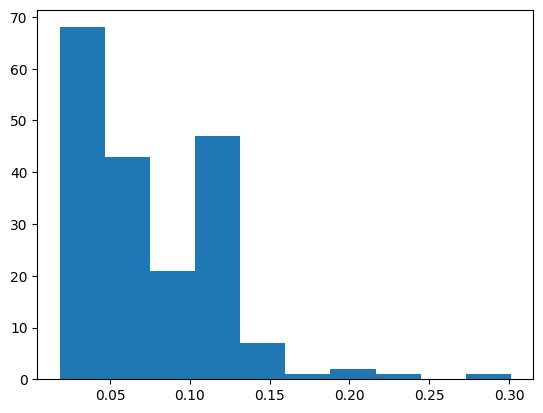

In [75]:
plt.hist( offsets - onsets )

In [76]:
np.median( offsets - onsets )

0.056641879784251614

In [1]:
from model import WhisperSegmenterFast, WhisperSegmenter
import librosa
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from train import evaluate
from datautils import get_audio_and_label_paths, read_label
import os
from audio_utils import SpecViewer
import subprocess
from glob import glob
import json

In [2]:
def evaluate_dataset( dataset_folder, model_path, num_trials, consolidation_method = "clustering",
                      max_length = 448, num_beams = 4, batch_size = 8 ):
    audio_list, label_list = [], []
    audio_paths, label_paths = get_audio_and_label_paths(dataset_folder)
    for audio_path, label_path in zip(audio_paths, label_paths):
        label = read_label( label_path )
        audio, sr = librosa.load( audio_path, sr = label.get("sr", None) )
        label["sr"] = sr
        audio_list.append(audio)
        label_list.append(label) 

    segmenter = WhisperSegmenterFast(  model_path = model_path,  device = "cuda")
    res = evaluate( audio_list, label_list, segmenter, batch_size, max_length, num_trials, consolidation_method, num_beams, target_cluster = None )

    all_res = {
        "segment_wise_scores": {"N-true-positive": res["segment_wise"][0],
                                "N-positive-in-prediction": res["segment_wise"][1],
                                "N-positive-in-ground-truth": res["segment_wise"][2],
                                "precision": res["segment_wise"][3],
                                "recall": res["segment_wise"][4],
                                "F1": res["segment_wise"][5]
                                },
        "frame_wise_scores": {"N-true-positive": res["frame_wise"][0],
                                "N-positive-in-prediction": res["frame_wise"][1],
                                "N-positive-in-ground-truth": res["frame_wise"][2],
                                "precision": res["frame_wise"][3],
                                "recall": res["frame_wise"][4],
                                "F1": res["frame_wise"][5]
                                }
    }
    return all_res

In [4]:
evaluate_dataset( "data/example_subset/Mouse/test/", "nccratliri/whisperseg-large-ms-ct2", num_trials =3 )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


{'segment_wise_scores': {'N-true-positive': 124,
  'N-positive-in-prediction': 125,
  'N-positive-in-ground-truth': 133,
  'precision': 0.992,
  'recall': 0.9323308270676691,
  'F1': 0.9612403100775192},
 'frame_wise_scores': {'N-true-positive': 5042,
  'N-positive-in-prediction': 5105,
  'N-positive-in-ground-truth': 5207,
  'precision': 0.9876591576885406,
  'recall': 0.9683118878432879,
  'F1': 0.9778898370830101}}